# PUI2016 - HW10 - Assignment 2
 
## vsg247

Repeating the in class Spatial Analysis of Citibike data comparing summer and winter data. 

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [213]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [214]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
import statsmodels.api as sm
import pysal as ps
import seaborn as sns
from matplotlib import colors
import shapely

%matplotlib inline

## Working with Shape File

### Loading Census Tract Shape File¶

In [215]:
# from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [216]:
# from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

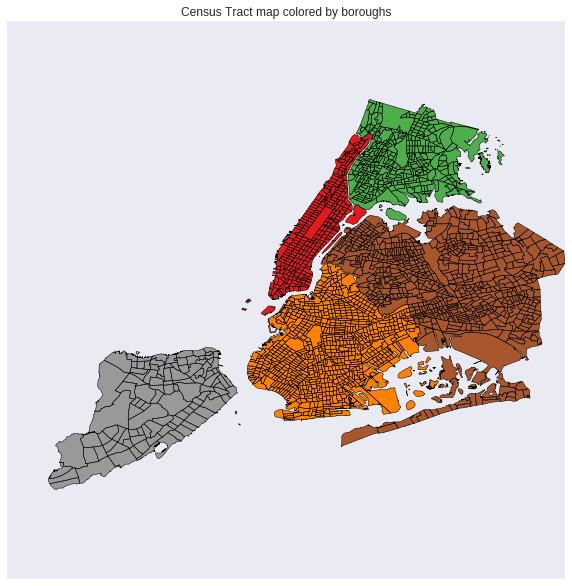

In [217]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

** FIGURE 01: Map of the Census Tracts for each one of NYC's Boroughs. **  

### Map NYC Population density

#### Load Census Data for 2010

In [218]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [219]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

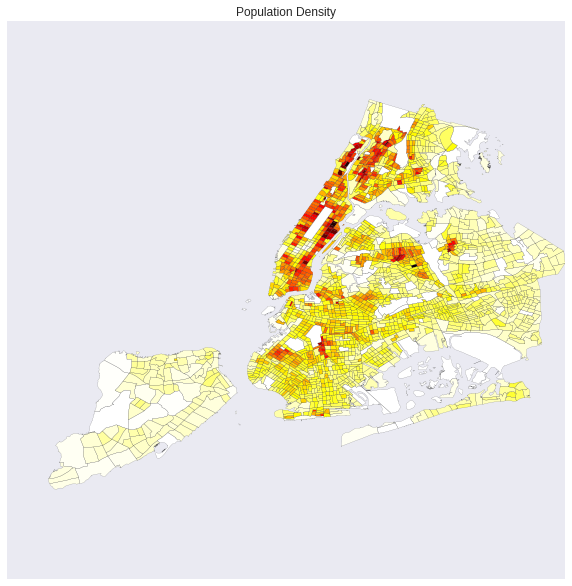

In [220]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

** FIGURE 02: Population Density by Census Tract in NYC. Data from American Community Survey 2010.**

## Explore CitiBike data

### Load CitiBike data

In [221]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


###  vsg247 - Splitting the data in Summer (May to October) and Winter (November to April)

In [222]:
# Summer data
df_bike_summer = pd.concat([df_bike_monthly['20130731':'20131101'],
                            df_bike_monthly['20140531':'20141101'],
                            df_bike_monthly['20150531':'20151101'],
                            df_bike_monthly['20160531':'20160701']], axis=0)


In [223]:
df_bike_summer.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2014-05-31,1696,3125,9070,3115,6207,2897,2049,3579,3863,2062,...,0,0,0,0,0,0,0,0,0,0


In [224]:
# Winter data
df_bike_winter = pd.concat([df_bike_monthly['20131130':'20140501'],
                            df_bike_monthly['20141130':'20150501'],
                            df_bike_monthly['20151130':'20160501']], axis=0)


In [225]:
df_bike_winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

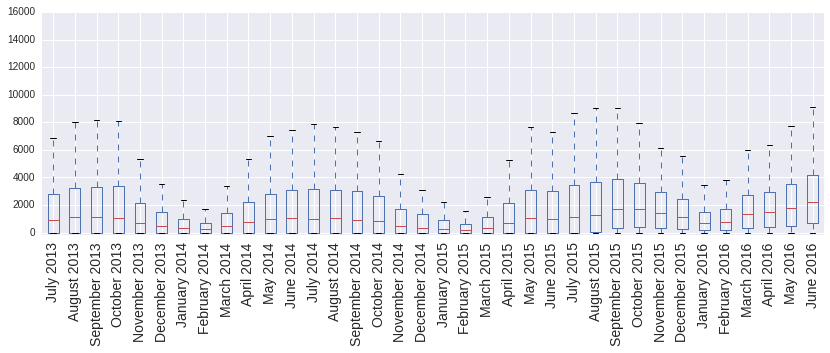

In [226]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

** FIGURE 03: Box Plot showing the time series of Citibike monthly ridership from July 2013 to June 2016. **

#### Seasonal Decomposition

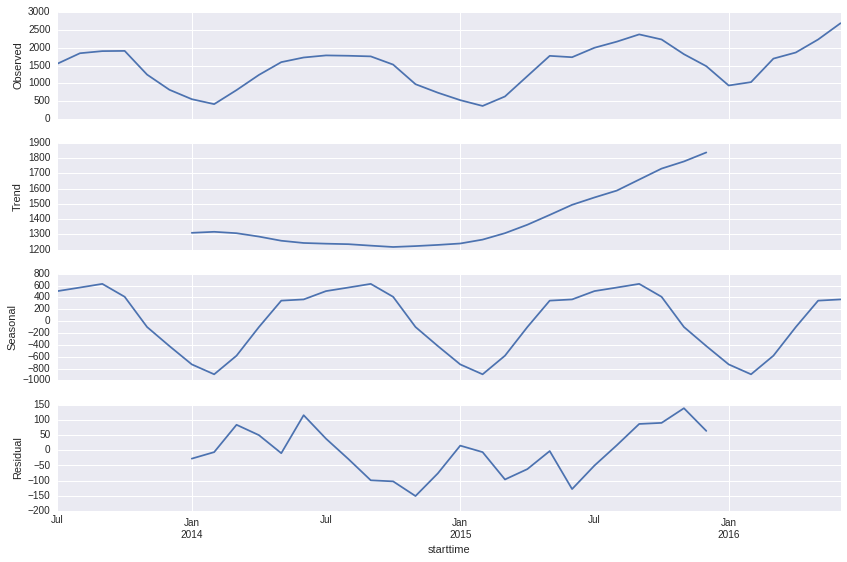

In [227]:
#import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

** FIGURE 04: Time series decomposition of monthly Citibike ridership from July 2013 to June 2016. The plot shows a clear seasonal variation with higher ridership in the warmer months (May to October) and a lower ridership during the colder months (November to April). Besides that, there is a clear trend of a steady increase in ridership starting around January 2015. **

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [228]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [229]:
# import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [230]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [231]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [232]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()
station_id['SummerAve'] = df_bike_summer.sum()
station_id['WinterAve'] = df_bike_winter.sum()

In [233]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,45373,23935
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,70620,32204
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,177744,95781
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,66116,35833
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,123644,60400


### Add the monthly average rides to the CT shapefile 

In [234]:
# use the 
temp=station_id[['MonthlyAve', 'SummerAve', 'WinterAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)


/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


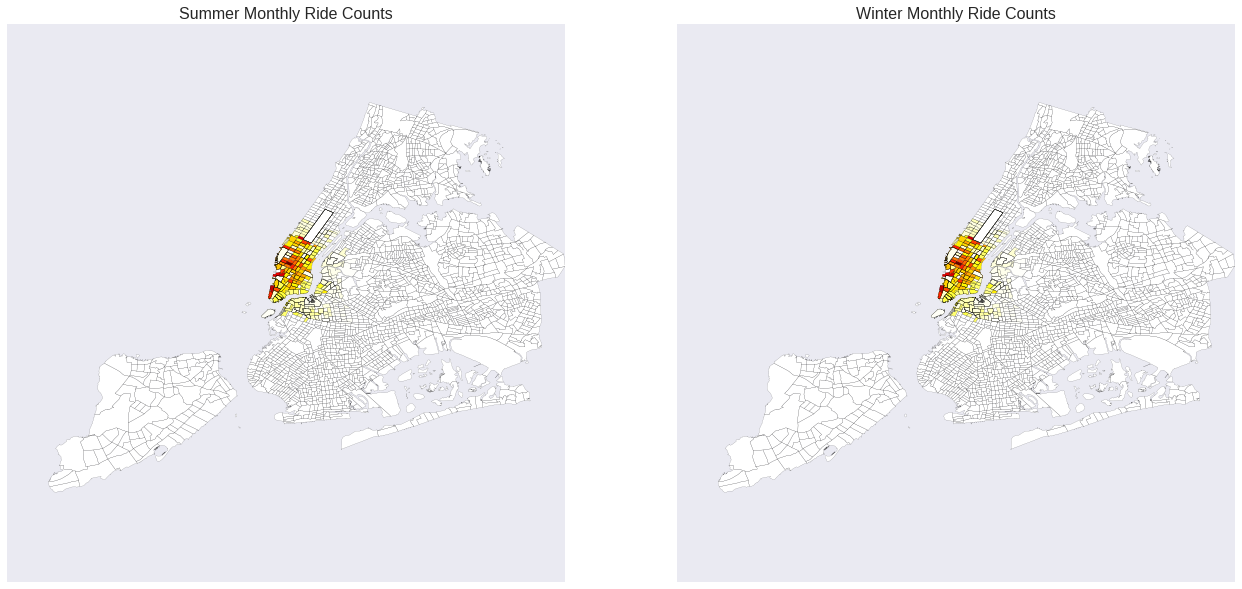

In [235]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22,10))
ct_shape_MonthlyAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title("Summer Monthly Ride Counts", fontsize=16)
ct_shape_MonthlyAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title("Winter Monthly Ride Counts", fontsize=16)

** FIGURE 05: Cloropleth map of Citibike ridership by census tract in NYC for Summer (May to October) and Winter (November to April). Data from July 2013 to June 2014. **

### Removing the CTs that are out of zoom boundries

In [236]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [237]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

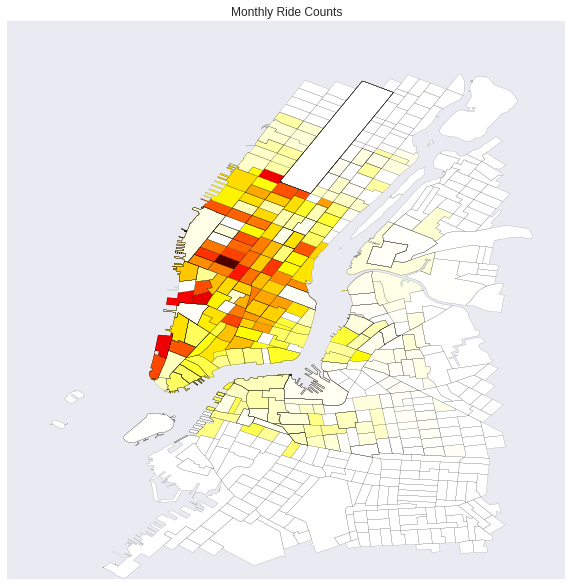

In [238]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

** FIGURE 06: Cloropleth map of Citibike ridership by census tract in NYC zoomed in to the area where there are actually citibike stations. Data from July 2013 to June 2014. **

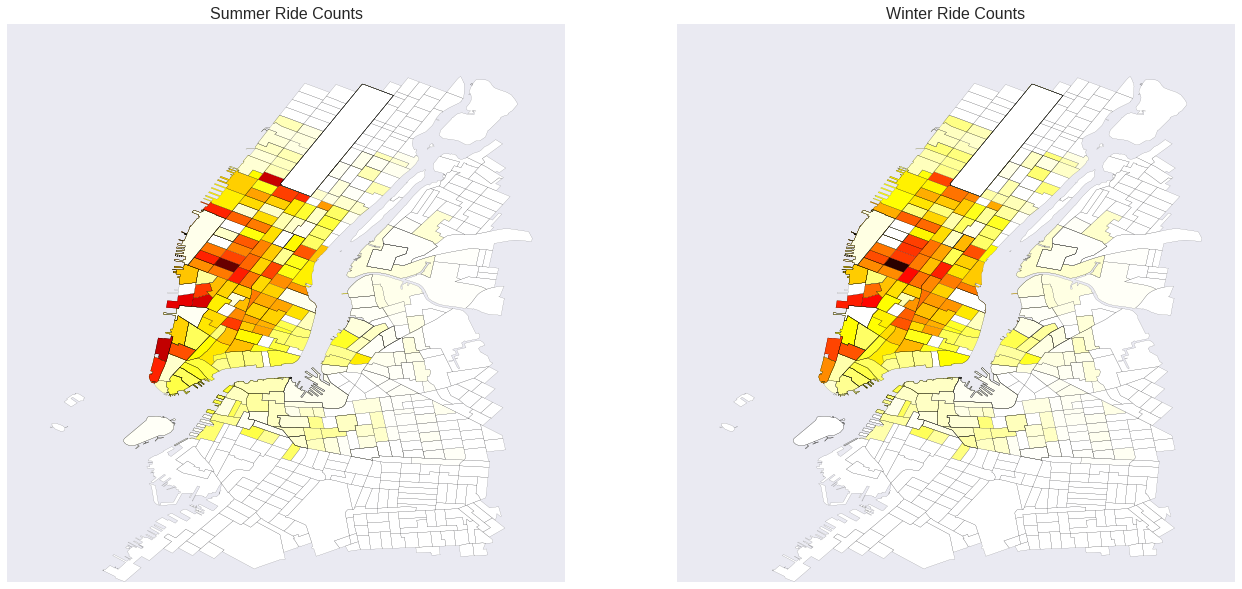

In [239]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22,10))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ct_shape_MonthlyAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax1.set_title("Summer Ride Counts", fontsize=16)
ax2.set_title("Winter Ride Counts", fontsize=16)

** FIGURE 07: Cloropleth map of Citibike ridership by census tract for Summer (May to October) and Winter (November to April) in NYC zoomed in to the area where there are actually citibike stations. Data from July 2013 to June 2014. **

### Export Shapefile CTs in the CitiBike Zone

In [240]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [241]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [242]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [243]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [244]:
Wmatrix, ids = qW_CT.full()

In [245]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [246]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [247]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

In [248]:
# Doing the same for Summer and Winter
SummerRide=ct_shape_MonthlyAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

WinterRide=ct_shape_MonthlyAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [249]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

In [250]:
# Doing the same for Summer
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   144.857                21
  144.857 < x[i] <=  2456.500                78
 2456.500 < x[i] <=  5724.889                80
 5724.889 < x[i] <= 11566.075                79
11566.075 < x[i] <= 17837.800                80
17837.800 < x[i] <= 37784.389                79
37784.389 < x[i] <= 55150.786                80
55150.786 < x[i] <= 63650.794                79
63650.794 < x[i] <= 97593.429                80

In [251]:
# Doing the same for Winter
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    92.714                 2
   92.714 < x[i] <=  1624.250                78
 1624.250 < x[i] <=  4018.294                80
 4018.294 < x[i] <=  6274.828                79
 6274.828 < x[i] <=  9356.333                80
 9356.333 < x[i] <= 20433.494                79
20433.494 < x[i] <= 27914.276                80
27914.276 < x[i] <= 33315.668                79
33315.668 < x[i] <= 54389.929                80

#### Map the monthly rides lag

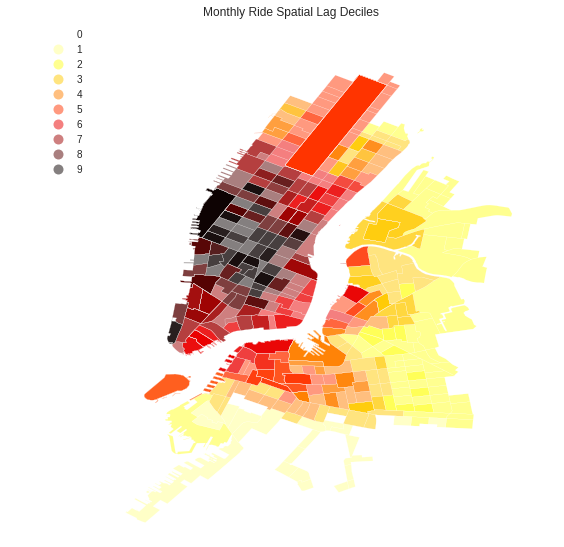

In [252]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


** FIGURE 08: Cloropleth map of the spatial lag deciles of citibik ridership by census tracts. The ridership for each census tract is estimated from the average of its census tracts contiguous to it (queen method). ** 

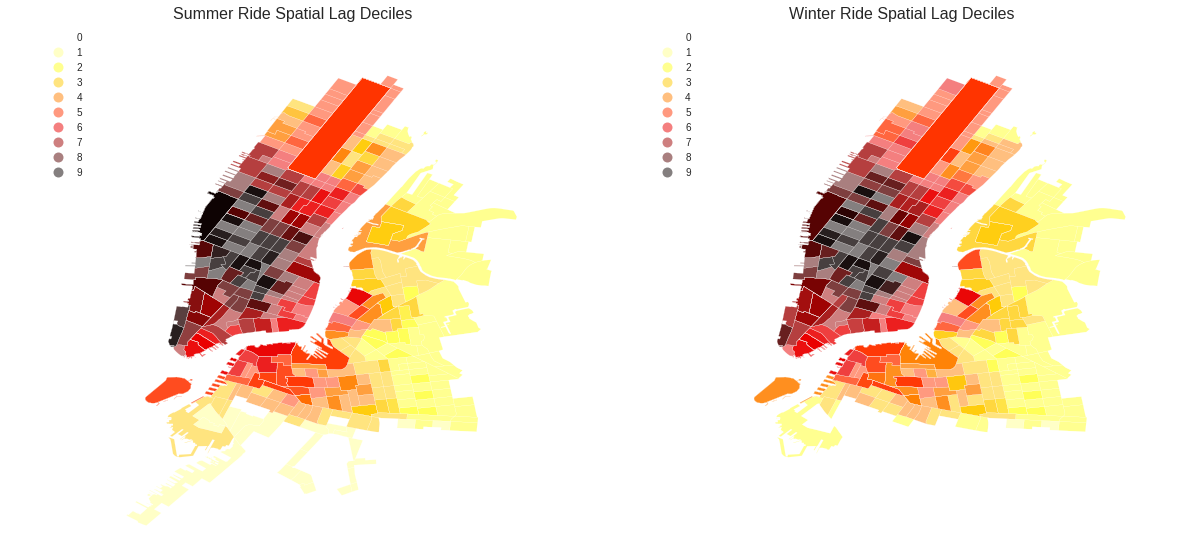

In [253]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_MonthlyAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title("Summer Ride Spatial Lag Deciles", fontsize=16)
ax2.set_title("Winter Ride Spatial Lag Deciles", fontsize=16)

** FIGURE 09: Cloropleth map of the spatial lag deciles of citibik ridership by census tracts for Summer (May to October) and Winter (November to April). The ridership for each census tract is estimated from the average of its census tracts contiguous to it (queen method). **

## Global  Spatial Autocorrelation

In [254]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

In [255]:
# Summer
b1, a1 = np.polyfit(SummerRide, SummerRideLag, 1)
b1, a1 

(0.64617661201524912, 8416.8106808882385)

In [256]:
# Winter
b2, a2 = np.polyfit(WinterRide, WinterRideLag, 1)
b2, a2 

(0.66125928920205468, 4293.6780316496952)

### Moran Scatterplot

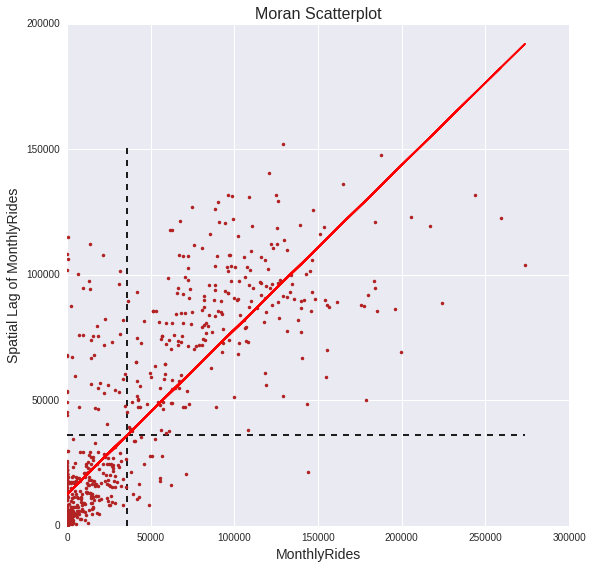

In [257]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot', fontsize=16)
plt.ylabel('Spatial Lag of MonthlyRides', fontsize=14)
plt.xlabel('MonthlyRides', fontsize=14)

** FIGURE 10: Moran Scatterplot for citibike ridership, showing a positive autocorrelation. **

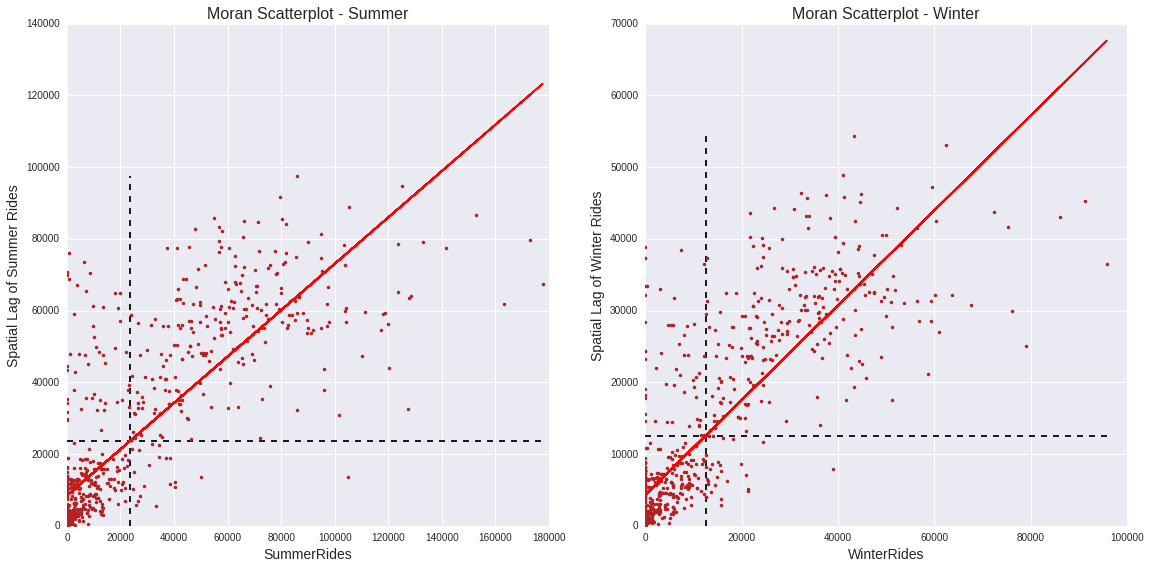

In [258]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 9))

ax1.plot(SummerRide, SummerRideLag, '.', color='firebrick')
ax2.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(SummerRide, a1 + b1*SummerRide, 'r')
ax1.set_title('Moran Scatterplot - Summer', fontsize=16)
ax2.plot(WinterRide, a2 + b2*WinterRide, 'r')
ax2.set_title('Moran Scatterplot - Winter', fontsize=16)
ax1.set_ylabel('Spatial Lag of Summer Rides', fontsize=14)
ax2.set_ylabel('Spatial Lag of Winter Rides', fontsize=14)
ax1.set_xlabel('SummerRides', fontsize=14)
ax2.set_xlabel('WinterRides', fontsize=14)

** FIGURE 11: Moran Scatterplot citibike ridership for Summer (May to October) and Winter (November to April), showing a positive autocorrelation in both seasons. **

### Moran's I

In [259]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [260]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [261]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)

I_SummerRide.I, I_SummerRide.p_sim

(0.64633998396618797, 0.001)

Thus, the $I$ statistic is $0.646$ for the Summer data, and has a very small $p$ value.

In [262]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)

I_WinterRide.I, I_WinterRide.p_sim

(0.66140507880103105, 0.001)

Thus, the $I$ statistic is $0.661$ for the Winter data, and has a very small $p$ value.

In [263]:
I_MonthlyRide.sim[0:10]

array([ 0.008569  ,  0.03629318,  0.0097934 , -0.00913395,  0.0305482 ,
        0.00027897, -0.03227394,  0.00178164, -0.00874629, -0.00324453])

In [264]:
I_SummerRide.sim[0:10]

array([-0.03046914, -0.00353992,  0.00478528, -0.00813599, -0.02412199,
       -0.01027451,  0.0044865 ,  0.00475221, -0.01348874, -0.00961313])

In [265]:
I_WinterRide.sim[0:10]

array([ 0.00560911, -0.00217663, -0.00030336, -0.03202854,  0.00984846,
       -0.01416372,  0.00712554,  0.01120216,  0.01582517, -0.0033358 ])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [266]:
#import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

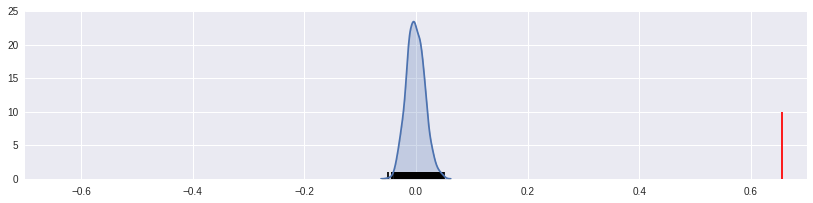

In [267]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

** FIGURE 12: Plot of the kernel densitiy estimation for all citibike ridership, ilustrating how significant are the statistics of that calculation.** 

#### Summer

(-0.7, 0.7)

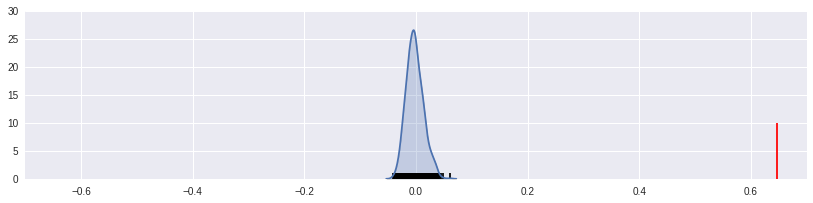

In [268]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

** FIGURE 13: Plot of the kernel densitiy estimation for citibike ridership in the Summer (May to October), ilustrating how significant are the statistics of that calculation.** 

#### Winter

(-0.7, 0.7)

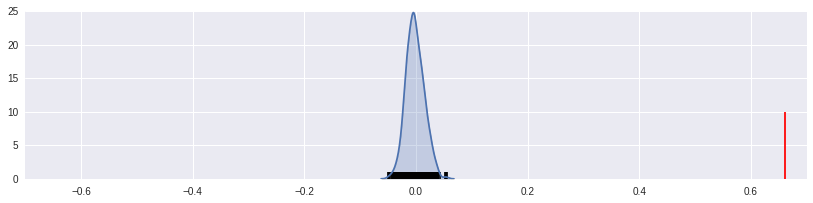

In [269]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

** FIGURE 14: Plot of the kernel densitiy estimation for citibike ridership in the Winter (November to April), ilustrating how significant are the statistics of that calculation.** 

## Local  Spatial Autocorrelation

In [270]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [271]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.159,  0.417,  0.387,  0.5  ]))

In [272]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23543136,  0.00791709,  0.00253392,  0.01772575]),
 array([ 0.001,  0.168,  0.367,  0.37 ,  0.384]))

In [273]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([ -0.00000000e+00,  -2.83046856e-01,  -6.06024526e-04,
          1.55249543e-04,  -3.66289401e-02]),
 array([ 0.001,  0.169,  0.424,  0.472,  0.447]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [274]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

In [275]:
# Summer
sigs1 = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs1 = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs1 = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs1 = SummerRideLag[LMo_SummerRide.p_sim > .001]

In [276]:
# Winter
sigs2 = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs2 = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs2 = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs2 = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

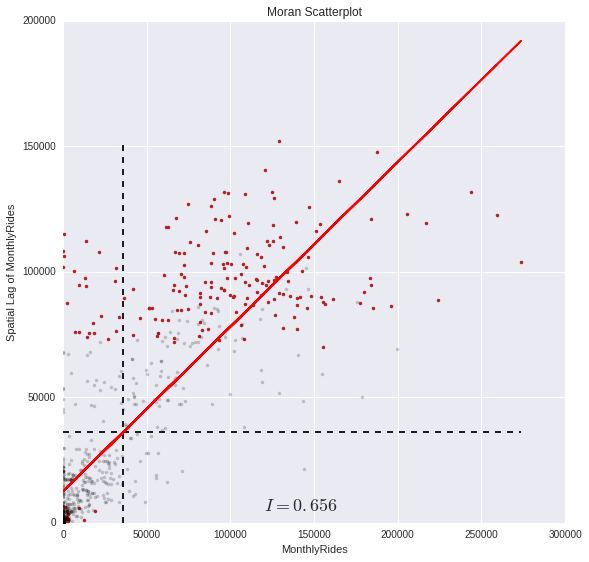

In [277]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


** FIGURE 15: Moran Scatterplot for all citibike ridership data, differentiating the points (census tracts) that have a statiscally significant correlation with its neighbors. **

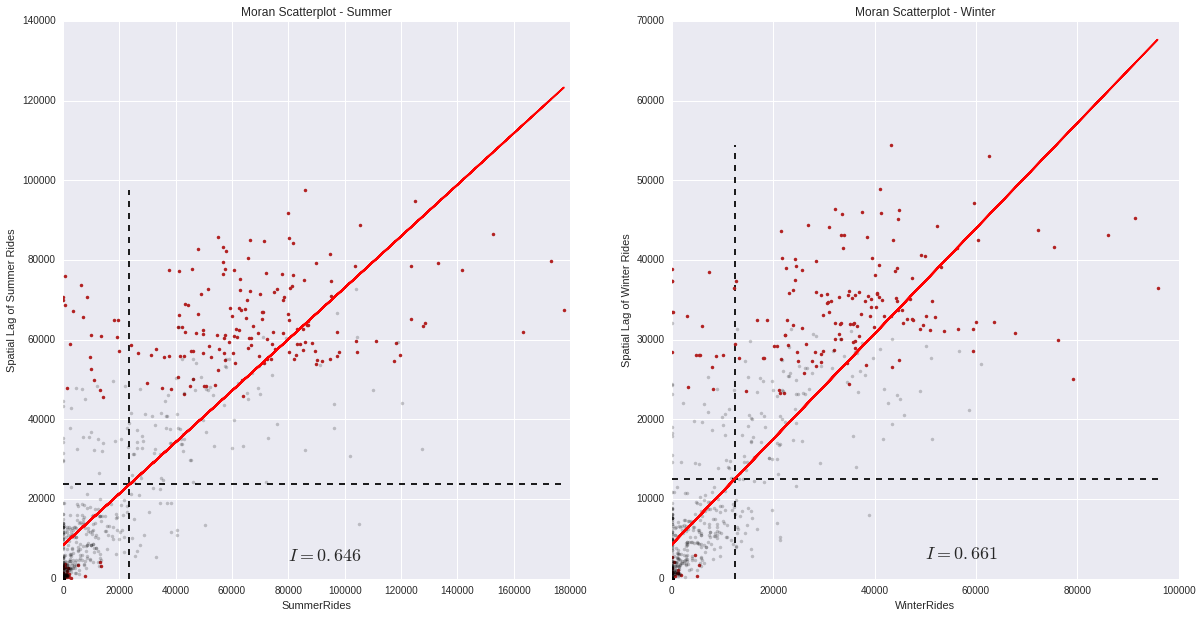

In [278]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# summer
ax1.plot(sigs1, W_sigs1, '.', color='firebrick')
ax1.plot(insigs1, W_insigs1, '.k', alpha=.2)
ax1.text(s='$I = %.3f$' % I_SummerRide.I, x=80000, y=4500, fontsize=18)

# winter
ax2.plot(sigs2, W_sigs2, '.', color='firebrick')
ax2.plot(insigs2, W_insigs2, '.k', alpha=.2)
ax2.text(s='$I = %.3f$' % I_WinterRide.I, x=50000, y=2500, fontsize=18)


# dashed vert at mean of the last year's PCI
ax1.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
ax2.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')

# dashed horizontal at mean of lagged PCI
ax1.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')
ax2.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(SummerRide, a1 + b1*SummerRide, 'r')
ax1.set_title('Moran Scatterplot - Summer')
ax2.plot(WinterRide, a2 + b2*WinterRide, 'r')
ax2.set_title('Moran Scatterplot - Winter')
ax1.set_ylabel('Spatial Lag of Summer Rides')
ax2.set_ylabel('Spatial Lag of Winter Rides')
ax1.set_xlabel('SummerRides')
ax2.set_xlabel('WinterRides')

** FIGURE 16: Moran Scatterplot of citibike ridership for Summer (May to October) and Winter (November to April), differentiating the points (census tracts) that have a statiscally significant correlation with its neighbors. **

### Hot and Cold spots 

In [279]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 190
Number of Coldspots: 237


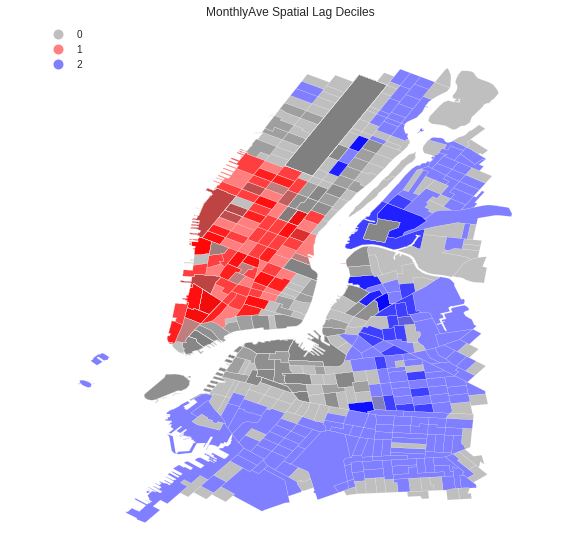

In [280]:
#from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

** FIGURE 17: Map of hot and cold spots for all citibike ridership data (July 2013 to June 2016).**

### Summer

In [281]:
sig1 = LMo_SummerRide.p_sim < 0.01
hotspots1 = LMo_SummerRide.q==1 * sig1
coldspots1 = LMo_SummerRide.q==3 * sig1
print "Number of Hotspots:", hotspots1.sum()
print "Number of Coldspots:", coldspots1.sum()

Number of Hotspots: 189
Number of Coldspots: 232


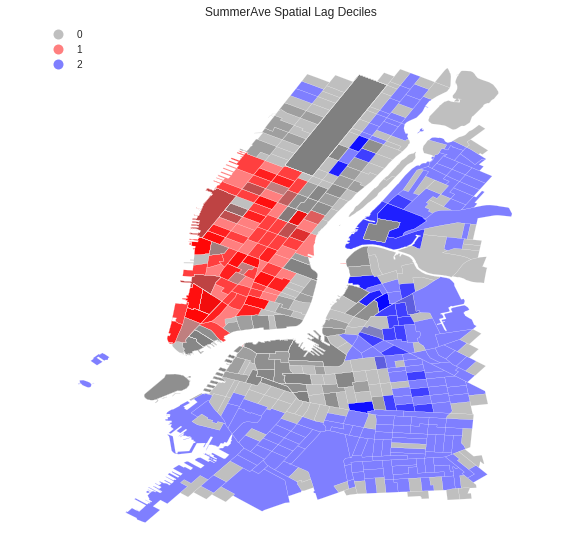

In [282]:
hcmap1 = colors.ListedColormap(['grey','red','blue'])
hotcold1 = hotspots1*1 + coldspots1*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold1).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap1, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SummerAve Spatial Lag Deciles")

** FIGURE 18: Map of hot and cold spots of citibike ridership for the Summer.**

### Winter

In [283]:
sig2 = LMo_WinterRide.p_sim < 0.01
hotspots2 = LMo_WinterRide.q==1 * sig1
coldspots2 = LMo_WinterRide.q==3 * sig1
print "Number of Hotspots:", hotspots2.sum()
print "Number of Coldspots:", coldspots2.sum()

Number of Hotspots: 193
Number of Coldspots: 229


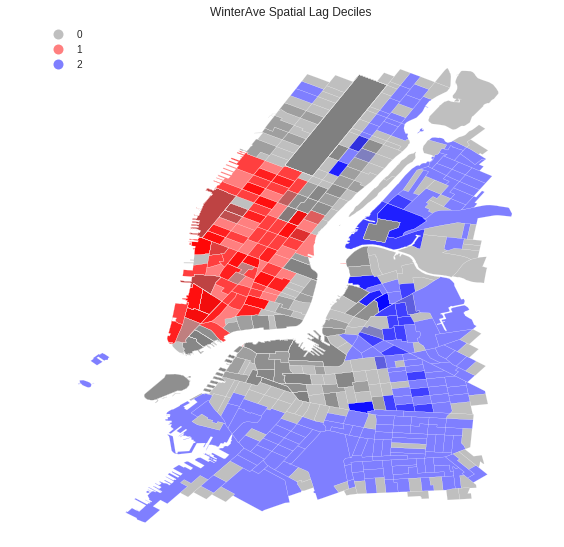

In [284]:
hcmap2 = colors.ListedColormap(['grey','red','blue'])
hotcold2 = hotspots2*1 + coldspots2*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold2).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap1, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WinterAve Spatial Lag Deciles")

** FIGURE 19: Map of hot and cold spots of citibike ridership for the Winter.**

The Summer and Winter spatial distributions were slightly different but no major changes in the spatial patterns could be identified. 
In the winter the spatial autocorrelation is a little stronger (Moran's I = 0.661) than in the summer (Moran's I = 0.646), but in both the significance level was pretty high (p-value = 0.001).
The number of hot and cold spots differed a bit from Summer to Winter. Which means that the number of individual census tracts that had ridership significantly correlated with its neighbors) changed a little from Summer to Winter. But in general the patterns were the same, showing no ridership where there are no bike stations (cold spots) and high ridership in South Manhattan, a little more concentrated in the west side. 